## Setup and Imports for Predicting Approval or rejection


In [1]:
# Step 0 — Setup
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, RocCurveDisplay
)
from joblib import dump

pd.set_option("display.max_columns", 100)
RANDOM_STATE = 42

# Project paths (adjust if your notebook lives elsewhere)
ROOT     = Path("..").resolve() if Path.cwd().name == "notebooks" else Path(".").resolve()
DATA_RAW = ROOT / "data" / "raw"
MODELS   = ROOT / "models"
REPORTS  = ROOT / "reports"
for d in [DATA_RAW, MODELS, REPORTS]:
    d.mkdir(parents=True, exist_ok=True)

CSV_PATH = DATA_RAW / "loan_approval_dataset.csv"
assert CSV_PATH.exists(), f"CSV not found at {CSV_PATH}"


## Load data & quick peek
#### confirm rows/columns and spot obvious issues early.

In [2]:
df = pd.read_csv(CSV_PATH)
print(df.shape)
df.head()  # peek at the data

(4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


## Clean column names, choose target, map labels ->{0,1}
### Binary target for classification

In [4]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(r"\s+", "_", regex=True)
      .str.replace("/", "_")
      .str.replace("-", "_")
)
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
target_col = "loan_status" if "loan_status" in df.columns else df.columns[-1]
print(f"Target column: {target_col}")

Target column: loan_status


In [9]:
def map_binary_strict(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.strip().str.lower()
    pos = {"approve","approved","y","yes","1","true"}
    neg = {"reject","rejected","n","no","0","false"}
    return s.map(lambda v: 1 if v in pos else (0 if v in neg else np.nan))

y = map_binary_strict(df[target_col])
keep = ~y.isna()
df = df.loc[keep].copy()
y = y.loc[df.index].astype(int)

print("Rows after cleaning:", df.shape[0])
y.value_counts(normalize=True).rename({0:"Reject",1:"Approve"}) * 100

Rows after cleaning: 4269


loan_status
Approve    62.215976
Reject     37.784024
Name: proportion, dtype: float64

## Data Audit and finding null values

In [10]:
missing = df.isna().mean().sort_values(ascending=False)
schema = pd.DataFrame({"dtype": df.dtypes, "missing_ratio": missing})
schema

,dtype,missing_ratio
loan_id,int64,0.0
no_of_dependents,int64,0.0
education,object,0.0
self_employed,object,0.0
income_annum,int64,0.0
loan_amount,int64,0.0
loan_term,int64,0.0
cibil_score,int64,0.0
residential_assets_value,int64,0.0
commercial_assets_value,int64,0.0


## Split Train/Test

In [11]:
# Step 4 — Split
X = df.drop(columns=[target_col])
num_cols = X.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["number"]).columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=RANDOM_STATE
)

len(X_train), len(X_test), len(num_cols), len(cat_cols)


(3415, 854, 10, 2)

## Preprocessing + Random Forest pipeline

In [ ]:
# Step 5 — Pipeline
numeric = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()) 
])

categorical = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocess = ColumnTransformer([
    ("num", numeric, num_cols),
    ("cat", categorical, cat_cols)
])

rf = RandomForestClassifier(
    n_estimators=400,
    random_state=RANDOM_STATE,
    class_weight="balanced",  # helpful if classes are imbalanced
    n_jobs=-1
)

rf_pipe = Pipeline([
    ("prep", preprocess),
    ("model", rf)
])


## Train the model

In [13]:
# Step 6 — Train
rf_pipe.fit(X_train, y_train)


Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['loan_id',
                                                   'no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'luxury_assets_value',
                                                   'bank_asset_value']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['education',
                                                   'self_employed'])])),
                ('model',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=400, n_jobs=-1,
                                        random_state=42))])

## Evalute (Accuracy)
### Precision, recall, F1, Auc to get clear picture

In [14]:
# Step 7 — Evaluate
y_pred = rf_pipe.predict(X_test)
y_prob = rf_pipe.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec  = recall_score(y_test, y_pred, zero_division=0)
f1   = f1_score(y_test, y_pred, zero_division=0)
auc  = roc_auc_score(y_test, y_prob)

print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print(f"ROC AUC  : {auc:.4f}")

print("\nClassification report:")
print(classification_report(y_test, y_pred, target_names=["Reject","Approve"]))


Accuracy : 0.9824
Precision: 0.9850
Recall   : 0.9868
F1-score : 0.9859
ROC AUC  : 0.9984

Classification report:
              precision    recall  f1-score   support

      Reject       0.98      0.98      0.98       323
     Approve       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



## Confusion Metrics & ROC curve

In [15]:
cm = confusion_matrix(y_test, y_pred)
pd.DataFrame(cm, index=["Actual Reject","Actual Approve"],
                columns=["Pred Reject","Pred Approve"])

,Pred Reject,Pred Approve
Actual Reject,315,8
Actual Approve,7,524


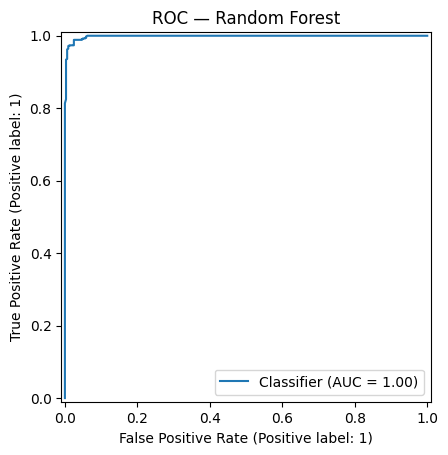

In [16]:
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title("ROC — Random Forest")
plt.show()

## Feature importance (top drivers)
### Understand which features influance decision

In [17]:
# Step 9 — Feature importance
ohe = rf_pipe.named_steps["prep"].named_transformers_.get("cat")
cat_names = ohe.named_steps["onehot"].get_feature_names_out(cat_cols) if (ohe and len(cat_cols)) else np.array([])
feat_names = np.concatenate([np.array(num_cols), cat_names])

importances = rf_pipe.named_steps["model"].feature_importances_
fi = pd.DataFrame({"feature": feat_names, "importance": importances}).sort_values("importance", ascending=False)
fi.head(20)
# Step 10 — Save model

,feature,importance
5,cibil_score,0.797974
4,loan_term,0.047665
3,loan_amount,0.029111
0,loan_id,0.020245
6,residential_assets_value,0.018517
8,luxury_assets_value,0.018498
7,commercial_assets_value,0.017892
2,income_annum,0.017270
9,bank_asset_value,0.015736
1,no_of_dependents,0.008785


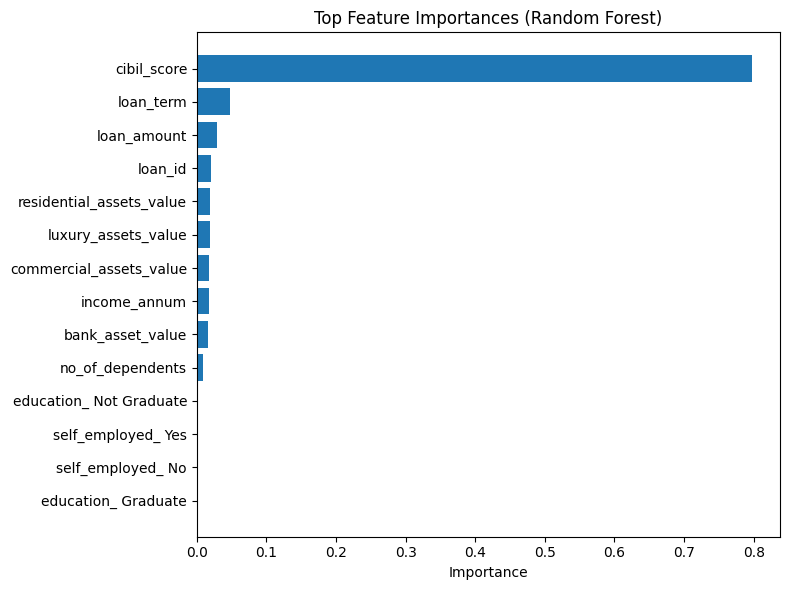

In [18]:
top_k = 15
plt.figure(figsize=(8,6))
plt.barh(fi.head(top_k)["feature"][::-1], fi.head(top_k)["importance"][::-1])
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

## Save the trained pipeline to resuse the exact preprocessing + model for interface and FastAPI.

In [19]:
# Step 10 — Save pipeline
model_path = MODELS / "loan_approval_rf_pipeline.joblib"
dump(rf_pipe, model_path)
model_path


PosixPath('/Users/priyankrupera/Documents/ML_Project/models/loan_approval_rf_pipeline.joblib')

In [21]:
# Step 10.1 — Save the exact training feature list (order matters)
from pathlib import Path
import json

feature_columns = X.columns.tolist()  # X is your training input dataframe BEFORE preprocessing
Path(MODELS).mkdir(parents=True, exist_ok=True)

feat_path = Path(MODELS) / "feature_columns.json"
feat_path.write_text(json.dumps({"features": feature_columns}, indent=2))
print("Wrote:", feat_path)
print("Num features:", len(feature_columns))


Wrote: /Users/priyankrupera/Documents/ML_Project/models/feature_columns.json
Num features: 12


## EMI Helper for adding rules on prediction 

In [24]:
# Step 11 — EMI helper & policy (tenure given in YEARS)

def compute_emi(principal: float, annual_rate: float, months: int) -> float:
    """
    EMI formula:
      E = P * r * (1+r)^n / ((1+r)^n - 1)
    where r = monthly interest rate (annual_rate/12), n = months
    """
    if principal is None or months is None or months <= 0:
        return None
    r = (annual_rate or 0.0) / 12.0
    if r <= 0:
        return principal / months
    pow_ = (1 + r) ** months
    return principal * r * pow_ / (pow_ - 1)

def apply_emi_policy_years(income_annum: float,
                           loan_amount: float,
                           loan_term_years: float,
                           annual_rate: float = 0.082):
    """
    Rule: EMI must be <= 50% of monthly income.
    - tenure is provided in YEARS; we convert to months internally.
    - monthly_income derived from annual income.
    """
    if income_annum is None or loan_amount is None or loan_term_years is None or loan_term_years <= 0:
        return {
            "emi": None, "monthly_income": None, "threshold": None,
            "rule_applied": False, "rule_reject": False,
            "reason": "Policy skipped (missing income_annum/loan_amount/loan_term_years)."
        }

    months = int(round(float(loan_term_years) * 12))
    monthly_income = float(income_annum) / 12.0
    emi = compute_emi(float(loan_amount), annual_rate, months)

    if emi is None:
        return {
            "emi": None, "monthly_income": monthly_income, "threshold": None,
            "rule_applied": False, "rule_reject": False,
            "reason": "Policy skipped (EMI not computable)."
        }

    threshold = 0.5 * monthly_income
    rule_reject = emi > threshold
    return {
        "emi": float(emi),
        "monthly_income": float(monthly_income),
        "threshold": float(threshold),
        "rule_applied": True,
        "rule_reject": bool(rule_reject),
        "reason": "EMI exceeds 50% of monthly income" if rule_reject else "EMI within safe limit"
    }


## inference helper that enforces the policy

In [25]:
# Step 12 — Predict with EMI policy gating (tenure in YEARS)

def predict_approval_with_policy_years(pipeline, sample: dict,
                                       threshold: float = 0.5,
                                       annual_rate: float = 0.082):
    """
    1) Get model probability + model_pred (0/1).
    2) Apply business policy using tenure in YEARS (converted to months for EMI).
    3) If policy fails, force final_pred = 0 (Reject).
    """
    import pandas as pd
    x = pd.DataFrame([sample])
    prob = float(pipeline.predict_proba(x)[:, 1][0])
    model_pred = int(prob >= threshold)

    income_annum = sample.get("income_annum")
    loan_amount  = sample.get("loan_amount")
    loan_term_y  = sample.get("loan_term") or sample.get("loan_term_years")  # your dataset uses years

    policy = apply_emi_policy_years(income_annum, loan_amount, loan_term_y, annual_rate=annual_rate)

    final_pred = 0 if (policy["rule_applied"] and policy["rule_reject"]) else model_pred

    return {
        "prob_approve": prob,
        "model_pred": model_pred,
        "final_pred": final_pred,
        "policy": policy
    }


## Test

In [30]:
# Step 13 — Example (tenure in YEARS)
example = {
    "loan_id": 101234,
    "no_of_dependents": 2,
    "education": "Graduate",
    "self_employed": "No",
    "income_annum": 840000,   # annual income
    "loan_amount": 600000,    # principal
    "loan_term": 1,           # YEARS (not months)
    "cibil_score": 720,
    "residential_assets_value": 500000,
    "commercial_assets_value": 0,
    "luxury_assets_value": 0,
    "bank_asset_value": 120000
}

predict_approval_with_policy_years(rf_pipe, example, threshold=0.5, annual_rate=0.0642)


{'prob_approve': 0.855,
 'model_pred': 1,
 'final_pred': 0,
 'policy': {'emi': 51755.75761141699,
  'monthly_income': 70000.0,
  'threshold': 35000.0,
  'rule_applied': True,
  'rule_reject': True,
  'reason': 'EMI exceeds 50% of monthly income'}}

In [20]:
api_dir = ROOT / "fastapi_app"
api_dir.mkdir(parents=True, exist_ok=True)

# main.py
(api_dir / "main.py").write_text("""
from typing import Optional, List
from fastapi import FastAPI
from pydantic import BaseModel, Field
from joblib import load
import pandas as pd
from pathlib import Path

APP = FastAPI(title="Loan Approval API", version="1.0")

MODEL_PATH = Path(__file__).resolve().parent.parent / "models" / "loan_approval_rf_pipeline.joblib"
PIPELINE = None

class LoanApplication(BaseModel):
    cibil_score: Optional[float] = Field(None, description="Credit score")
    income: Optional[float] = None
    employment_status: Optional[str] = None
    loan_term: Optional[float] = None
    loan_amount: Optional[float] = None
    assets_value: Optional[float] = None
    luxury_assets_value: Optional[float] = None
    bank_asset_value: Optional[float] = None
    no_of_dependents: Optional[float] = None
    education: Optional[str] = None
    self_employed: Optional[str] = None

class PredictionResponse(BaseModel):
    pred: int
    prob_approve: float

@APP.on_event("startup")
def load_model():
    global PIPELINE
    if not MODEL_PATH.exists():
        raise FileNotFoundError(f"Model not found at {MODEL_PATH}. Train & save it first.")
    PIPELINE = load(MODEL_PATH)

@APP.get("/ping")
def ping():
    return {"status": "ok"}

@APP.post("/predict", response_model=PredictionResponse)
def predict(app: LoanApplication, threshold: float = 0.5):
    assert PIPELINE is not None, "Model not loaded"
    X = pd.DataFrame([app.dict()])
    prob = float(PIPELINE.predict_proba(X)[:, 1][0])
    pred = int(prob >= threshold)
    return {"pred": pred, "prob_approve": prob}

@APP.post("/predict_batch")
def predict_batch(apps: List[LoanApplication], threshold: float = 0.5):
    assert PIPELINE is not None, "Model not loaded"
    X = pd.DataFrame([a.dict() for a in apps])
    probs = PIPELINE.predict_proba(X)[:, 1]
    preds = (probs >= threshold).astype(int)
    return {"pred": preds.tolist(), "prob_approve": probs.tolist()}
""")

# requirements.txt for the API
(api_dir / "requirements.txt").write_text("""fastapi>=0.110
uvicorn[standard]>=0.27
pandas>=2.0
scikit-learn>=1.3
joblib>=1.3
numpy>=1.23
""")

print("Wrote:", api_dir / "main.py")
print("Wrote:", api_dir / "requirements.txt")

Wrote: /Users/priyankrupera/Documents/ML_Project/fastapi_app/main.py
Wrote: /Users/priyankrupera/Documents/ML_Project/fastapi_app/requirements.txt
